In [ ]:
import sys

import os

Mounted at /content/drive


In [ ]:
!pip install -U bitsandbytes transformers accelerate pymatgen

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.5/137.5 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 99.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 315.1/315.1 kB 24.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 68.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 87.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.9/48.9 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 332.3/332.3 kB 21.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 561.4/561.4 kB 41.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.8/117.8 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 50.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 526.7/52

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from transformers import AutoModel, AutoTokenizer, BitsAndBytesConfig

from pymatgen.core import Composition
from scipy.stats import spearmanr

import json
import torch

from transformers import BitsAndBytesConfig

In [ ]:
model_id = "meta-llama/Meta-Llama-3.1-8B"                # Choose the LLM
output_file_name = model_id.split("/")[-1]            # Choose the output filename

In [ ]:
elements_names = [
    "Hydrogen", "Helium", "Lithium", "Beryllium", "Boron", "Carbon", "Nitrogen", "Oxygen", "Fluorine", "Neon", "Sodium", "Magnesium", "Aluminium", "Silicon", "Phosphorus", "Sulfur", "Chlorine", "Argon",
    "Potassium", "Calcium", "Scandium", "Titanium", "Vanadium", "Chromium", "Manganese", "Iron", "Cobalt", "Nickel", "Copper", "Zinc", "Gallium", "Germanium", "Arsenic", "Selenium", "Bromine", "Krypton",
    "Rubidium", "Strontium", "Yttrium", "Zirconium", "Niobium", "Molybdenum", "Technetium", "Ruthenium", "Rhodium", "Palladium", "Silver", "Cadmium", "Indium", "Tin", "Antimony", "Tellurium", "Iodine", "Xenon",
    "Cesium", "Barium", "Lanthanum", "Cerium", "Praseodymium", "Neodymium", "Promethium", "Samarium", "Europium", "Gadolinium", "Terbium", "Dysprosium", "Holmium", "Erbium", "Thulium", "Ytterbium", "Lutetium", "Hafnium",
    "Tantalum", "Tungsten", "Rhenium", "Osmium", "Iridium",  "Platinum",  "Gold", "Mercury", "Thallium", "Lead", "Bismuth", "Polonium", "Astatine", "Radon", "Francium", "Radium", "Actinium", "Thorium",
    "Protactinium", "Uranium", "Neptunium", "Plutonium", "Americium", "Curium", "Berkelium", "Californium", "Einsteinium", "Fermium", "Mendelevium", "Nobelium", "Lawrencium", "Rutherfordium", "Dubnium", "Seaborgium", "Bohrium", "Hassium", "Meitnerium",
    "Darmstadtium", "Roentgenium", "Copernicium", "Nihonium", "Flerovium", "Moscovium", "Livermorium", "Tennessine", "Oganesson",
]

elements_symbols = [
    "H", "He", "Li", "Be", "B", "C", "N", "O", "F", "Ne", "Na" , "Mg", "Al", "Si", "P", "S", "Cl", "Ar",
    "K", "Ca", "Sc", "Ti", "V", "Cr", "Mn", "Fe", "Ni", "Co", "Cu", "Zn", "Ga", "Ge", "As", "Se", "Br", "Kr",
    "Rb", "Sr", "Y", "Zr", "Nb", "Mo", "Tc", "Ru", "Rh", "Pd", "Ag", "Cd", "In", "Sn", "Sb", "Te", "I", "Xe",
    "Cs", "Ba", "La", "Ce", "Pr", "Nd", "Pm", "Sm", "Eu", "Gd", "Tb", "Dy", "Ho", "Er", "Tm", "Yb", "Lu", "Hf",
    "Ta", "W", "Re", "Os", "Ir", "Pt", "Au", "Hg", "Tl", "Pb", "Bi", "Po", "At", "Rn", "Fr", "Ra", "Ac", "Th",
    "Pa", "U", "Np", "Pu", "Am", "Cm", "Bk", "Cf", "Es", "Fm", "Md", "No", "Rf", "Db", "Sg", "Bh", "Hs", "Mt",
    "Ds", "Rg", "Cn", "Nh", "Fl", "Mc", "Lv", "Ts", "Og"
]

In [ ]:
def generate_token_embeddings(model, tokenizer, text):

    # Tokenize input text
    tokens = tokenizer(text, return_tensors='pt')
    tokens = {key: value.to('cuda') for key, value in tokens.items()}

    # Forward pass through the model to get embeddings
    with torch.no_grad():
        outputs = model(**tokens)

    # Extract embeddings from specified layers
    embeddings = outputs.last_hidden_state[:,:]

    return embeddings

In [ ]:
MY_TOKEN = "" #Add your huggingface token here

In [ ]:
bnb_config = BitsAndBytesConfig(load_in_8bit=True, llm_int8_threshold=3.0, device_map = "auto")

device = "cuda" if torch.cuda.is_available() else "cpu"

tokenizer = AutoTokenizer.from_pretrained(model_id, token = MY_TOKEN)
model = AutoModel.from_pretrained(model_id, token = MY_TOKEN, quantization_config=bnb_config)

NameError: name 'BitsAndBytesConfig' is not defined

Generally uppercase prefix and lowercase queries lead to the best result feel fre to play with it

In [ ]:
prefix = [
    "",
    "insulator",
    "transparent",
    "non-metallic",
    "wide-bandgap",
    "photovoltaic",
    "optoelectronic",
    "high-resistivity",
    "UV-absorbing",
    "oxide",
    "nitride",
    "sulfide",
    "gallium nitride",
    "silicon carbide"
]

queries = [
    "",
    "insulator",
    "transparent",
    "non-metallic",
    "wide-bandgap",
    "photovoltaic",
    "optoelectronic",
    "high-resistivity",
    "UV-absorbing",
    "oxide",
    "nitride",
    "sulfide",
    "gallium nitride",
    "silicon carbide"
]

In this case we are theaking the mean of the output embeddings

In [ ]:
model_embeddings = {"el_embeddings":{}, "query":{}}

for p in prefix:
  model_embeddings["el_embeddings"][p] = {}
  for el in elements_names:
      model_embeddings["el_embeddings"][p][el.lower()] = (torch.mean(generate_token_embeddings(model, tokenizer, p +" " + el.lower()), 1)).detach().cpu().numpy().tolist()

for q in queries:
  model_embeddings["query"][q] = torch.mean(generate_token_embeddings(model, tokenizer, q),1).detach().cpu().numpy().tolist()

We detected that you are passing `past_key_values` as a tuple and this is deprecated and will be removed in v4.43. Please use an appropriate `Cache` class (https://huggingface.co/docs/transformers/v4.41.3/en/internal/generation_utils#transformers.Cache)


In [ ]:
with open("drive/MyDrive/LLM_scores/"+output_file_name+".json", "w") as f:
  json.dump(model_embeddings, f, indent = 4)

# Results

The following code assess the performance of the generated embeddings and it does not need to run on colab. Consider moving this part in a separate script that runs locally.

In [ ]:
DATA_DIR = #path to data file

symbol_2_name = {elements_symbols[i]:elements_names[i].lower() for i in range(len(elements_symbols))}
name_2_symbol = {elements_names[i].lower():elements_symbols[i] for i in range(len(elements_symbols))}

with open(DATA_DIR) as f:
        data = json.load(f)

names, values = [], []

names = data["Train"]["Name"] + data["Test"]["Name"] + data["Validation"]["Name"]  # list of compounds names
values = data["Train"]["Tc"] + data["Test"]["Tc"] + data["Validation"]["Tc"]  # list of curie temperatures

table = np.zeros((len(model_embeddings["el_embeddings"]), len(model_embeddings["query"])))  # Initialization of the heatmap

for a, prefix in enumerate(model_embeddings["el_embeddings"]):
    for b, query in enumerate(model_embeddings["query"]):

        embeddings = model_embeddings["el_embeddings"][prefix]
        embeddings["aluminum"] = embeddings["aluminium"]
        query = np.asarray(model_embeddings["query"][query])[0]

        query /= np.linalg.norm(query)

        X_data = []
        y_data = []

        for i in range(len(names)):

            comp = Composition(names[i])
            emb = np.zeros(len(embeddings["iron"][0]))

            # Compositional weighted average of the embeddings
            for el in comp:
                emb += (embeddings[symbol_2_name[str(el)]][0]/np.linalg.norm(embeddings[symbol_2_name[str(el)]][0]))*comp.get_atomic_fraction(el)

            X_data.append(emb)
            y_data.append(np.median(values[i]))   # if we have multiple values of Tc for one compound we pick the median value as reference value

        # Dot product between the Compositional weighted average elemental embeddings and the normalised query ammbeddings
        for i, x in enumerate(X_data):
            X_data[i] = np.dot(x, query)

        df = pd.DataFrame(data={"score":X_data, "tc": y_data})

        # Ranking of the data with respect to the scores and with respect to their Curie temp
        df["X_rank"] = df["score"].rank(ascending=True, method="min")
        df["y_rank"] = df["tc"].rank(ascending=True, method="min")

        X_train = df["X_rank"]
        y_train = df["y_rank"]

        table[a][b] = spearmanr(y_train, b=X_train).correlation

        print(a, b, table[a][b])

0 0 0.20172173956641606
0 1 -0.280537408562071
0 2 -0.07992151988412205
0 3 -0.0724139524881149
0 4 -0.16792171372342043
0 5 -0.26783764695819884
0 6 -0.32790101586686976
0 7 -0.27741809401431444
0 8 -0.06604332028300573
0 9 0.13035289373606584
0 10 -0.06596955168718838
0 11 0.006481857891411411
0 12 -0.2012761478408837
0 13 -0.28695053586531577
1 0 0.21640723095011105
1 1 0.2350755955585081
1 2 0.21369793628542583
1 3 0.2051535812099618
1 4 0.23067921225535232
1 5 0.2321318031991123
1 6 0.21254656758381252
1 7 0.1899908227538514
1 8 0.2948507514455692
1 9 0.28649072136545173
1 10 0.30696387670526265
1 11 0.4318404182496087
1 12 0.058674902501825436
1 13 0.010179512577893289
2 0 0.23258697710352946
2 1 0.30044484107224684
2 2 0.2074927821661654
2 3 0.20401849928431431
2 4 0.19300099707409155
2 5 0.0898382094934651
2 6 0.06964110529526851
2 7 0.10322927915070437
2 8 0.1499889367793113
2 9 0.3159243528852131
2 10 0.2864304609494303
2 11 0.3939186379984315
2 12 -0.00795959692490313
2 13 -

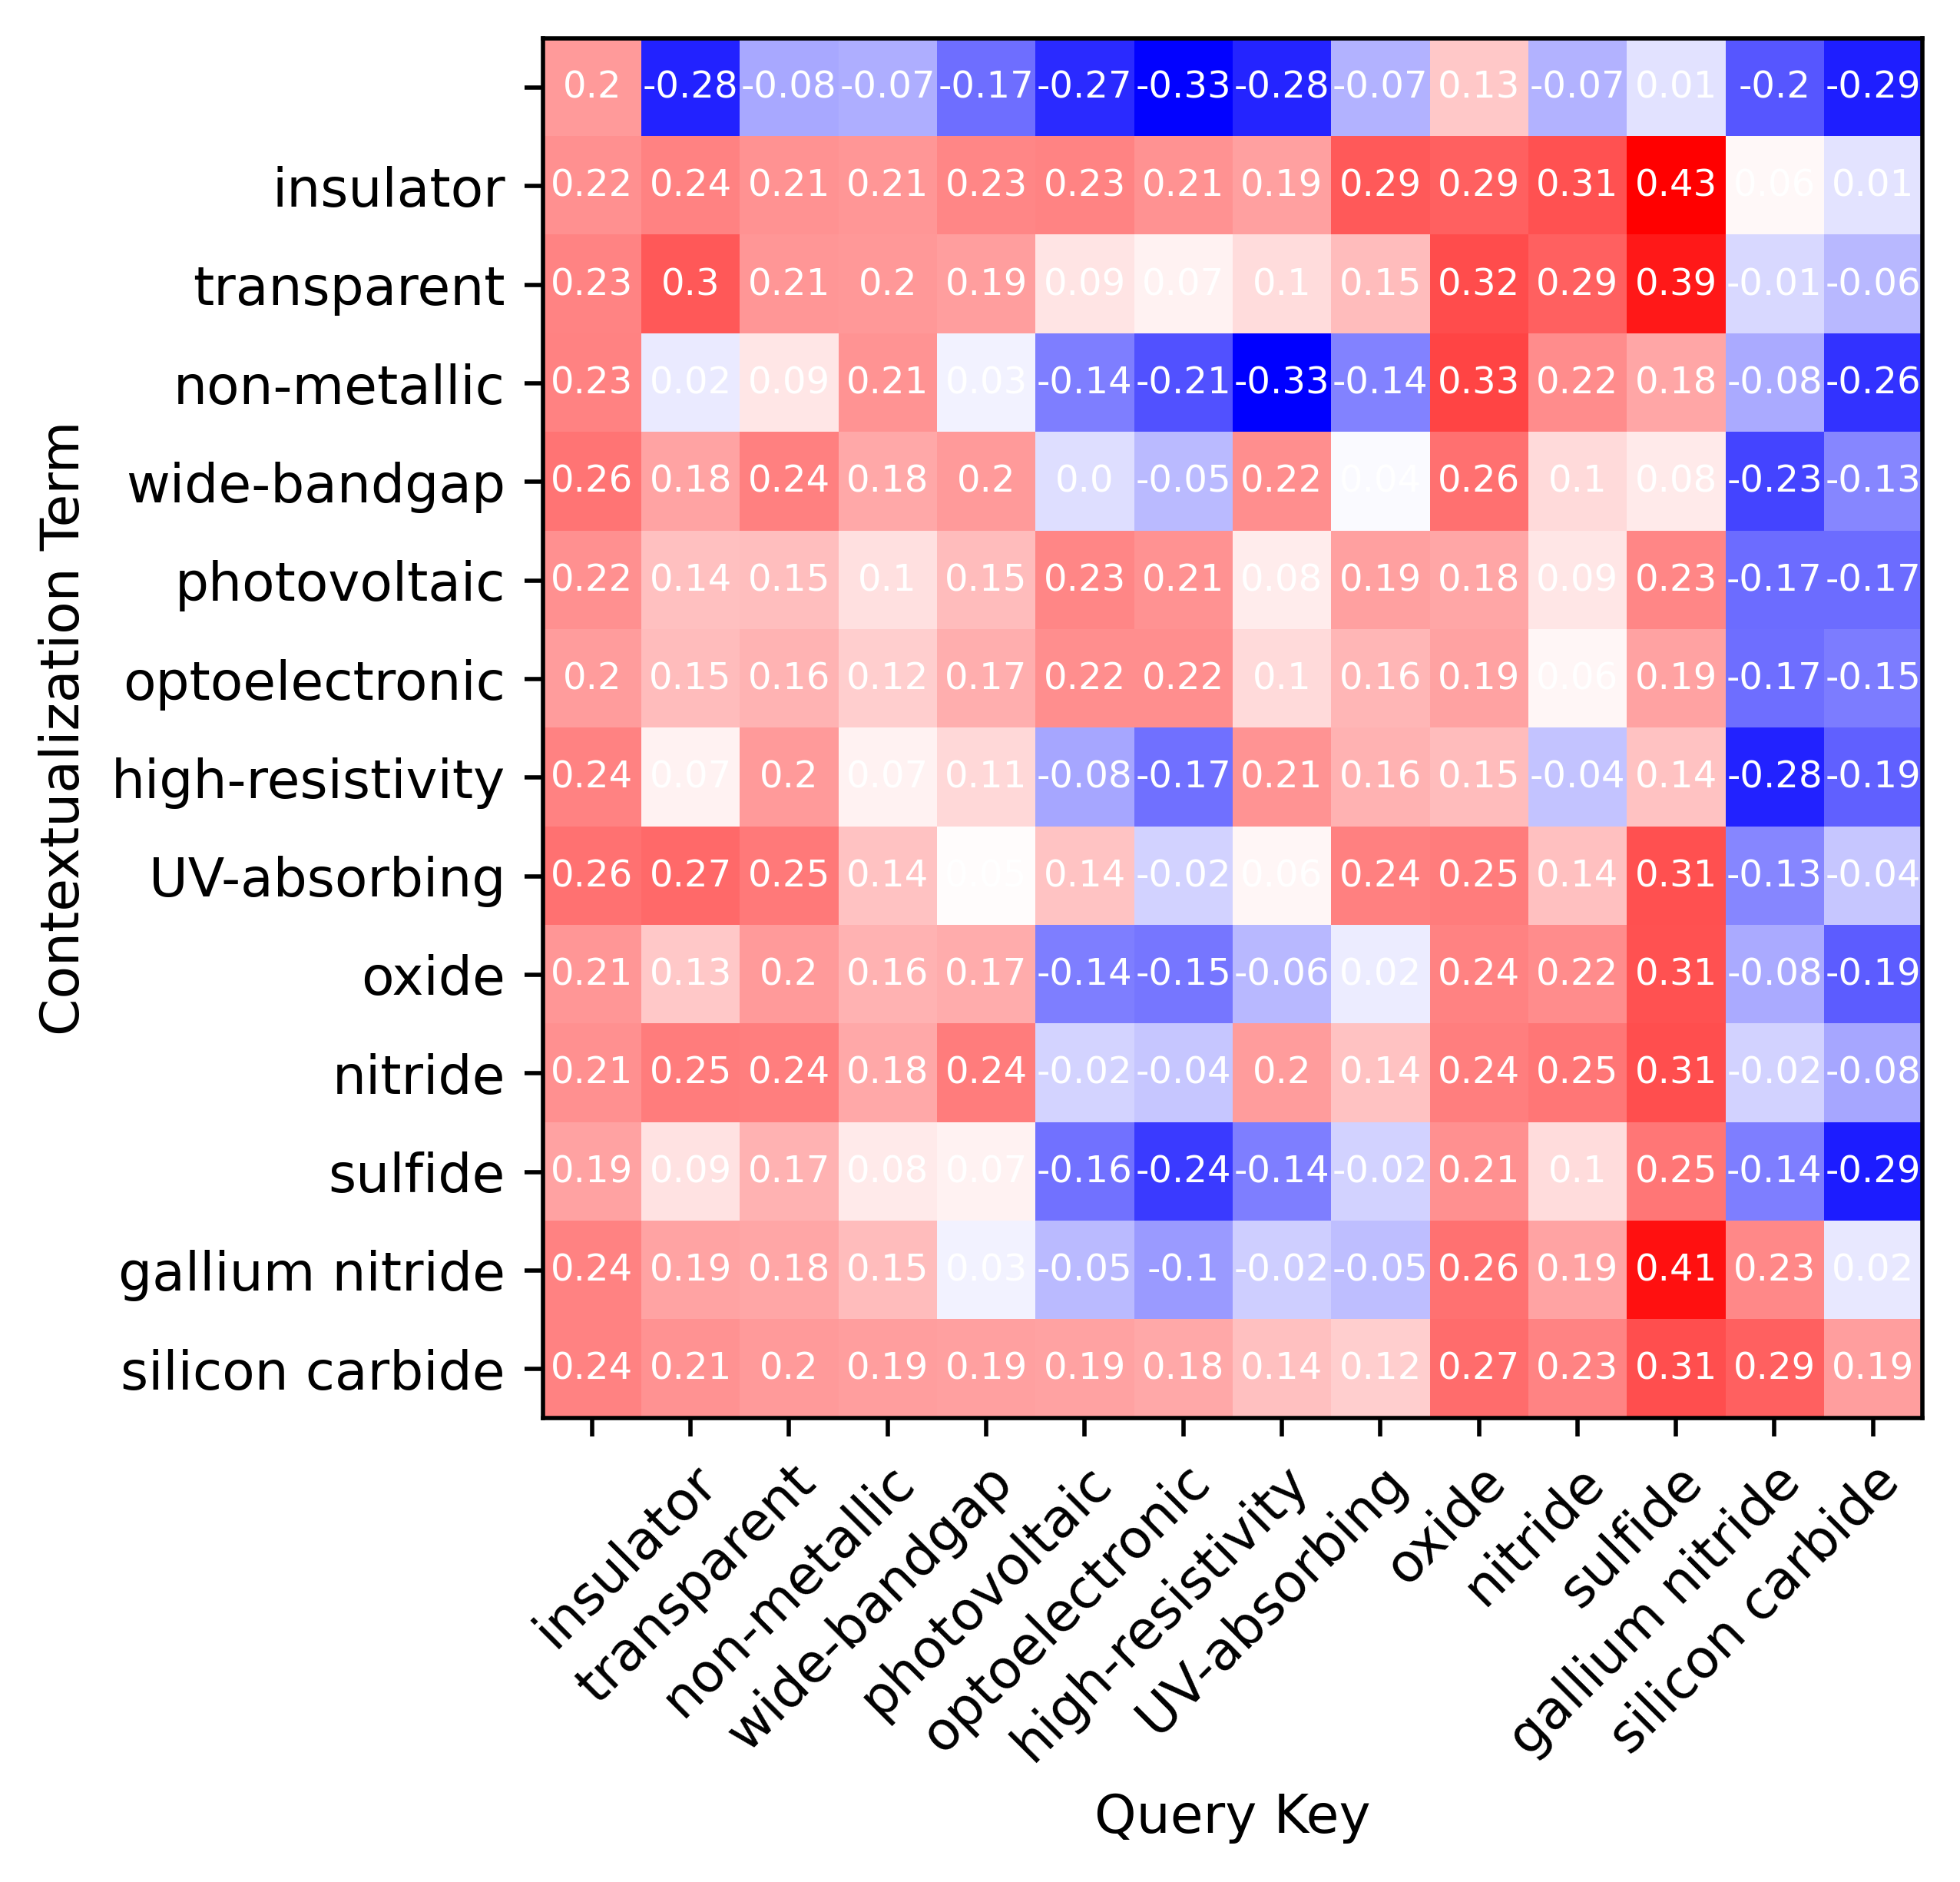

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(20, 5), dpi=500)

im = ax.imshow(table, cmap="bwr")

ax.set_yticks(np.arange(len(model_embeddings["el_embeddings"])), labels=[label for label in model_embeddings["el_embeddings"]])
ax.set_xticks(np.arange(len(model_embeddings["query"])), labels=[label for label in model_embeddings["query"]])

plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

for i in range(len(table)):
    for j in range(len(table[i])):
        text = ax.text(j, i, round(table[i, j], 2), ha="center", va="center", color="w", fontsize='x-small')

plt.xlabel("Query Key")
plt.ylabel("Contextualization Term")

fig.tight_layout()

OUTPUT_FILE = 

fig.savefig(OUTPUT_FILE, bbox_inches="tight")